In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling
import numpy as np
from scipy.stats import norm

# Load the dataset
df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')

# Show initial class distribution to understand the problem
print("Initial class distribution in df['Top10']:")
print(df['Top10'].value_counts())

# Show count before outlier removal
print(f"Number of rows before outlier removal: {df.shape[0]}")

# Define a function to remove outliers using the IQR method
def remove_outliers_iqr(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply IQR outlier removal to numerical columns with a less aggressive factor
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Apply outlier removal conservatively to ensure class balance is maintained
for col in numerical_columns:
    df = remove_outliers_iqr(df, col, factor=0.5)  # Using a very conservative factor

# Show count after outlier removal
print(f"Number of rows after outlier removal: {df.shape[0]}")

# Check class distribution after outlier removal
print("Class distribution in df['Top10'] after outlier removal:")
print(df['Top10'].value_counts())

# If there's only one class left, skip outlier removal
if df['Top10'].nunique() < 2:
    print("Warning: Only one class left after outlier removal. Skipping outlier removal.")
    df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')  # Reload the original data

# Identify categorical columns and apply one-hot encoding
categorical_columns = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Convert any boolean columns to integers
boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

# Split data by year: train up to 2009, test on 2010
train_df = df_encoded[df_encoded['year'] <= 2009]
test_df = df_encoded[df_encoded['year'] == 2010]

# Check class distribution after splitting
print("Class distribution in train_df['Top10']:")
print(train_df['Top10'].value_counts())

print("Class distribution in test_df['Top10']:")
print(test_df['Top10'].value_counts())

# Ensure both classes are present in training data
if train_df['Top10'].nunique() < 2:
    print("Training data does not have enough classes. Applying oversampling to balance classes.")
    
    # Use SMOTE to oversample the minority class only if there's exactly one class
    smote = SMOTE(random_state=42)
    
    # Apply SMOTE if there is only one class
    if train_df['Top10'].nunique() == 1:
        # Separate features and target variable for SMOTE
        X_train_smote, y_train_smote = smote.fit_resample(train_df.drop(columns=['Top10']), train_df['Top10'])
        # Convert to DataFrame for consistency
        train_df = pd.DataFrame(X_train_smote, columns=train_df.drop(columns=['Top10']).columns)
        train_df['Top10'] = y_train_smote

        # Check class distribution after oversampling
        print("Class distribution in train_df['Top10'] after SMOTE:")
        print(train_df['Top10'].value_counts())

# Separate features and target variable
X_train = train_df.drop(columns=['Top10'])
y_train = train_df['Top10']

X_test = test_df.drop(columns=['Top10'])
y_test = test_df['Top10']

# Final check before model fitting
if y_train.nunique() < 2:
    raise ValueError("Training data still does not have enough classes after all adjustments.")

# Check class distribution in the training set
print("Class distribution in y_train:")
print(y_train.value_counts())

# Normalize features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit logistic regression using scikit-learn
log_reg = LogisticRegression(max_iter=10000, solver='lbfgs')
log_reg.fit(X_train, y_train)

# Get the coefficients
coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_[0]

# Bootstrap to estimate standard errors
n_iterations = 1000
bootstrap_coefs = []

for i in range(n_iterations):
    # Resample the training data
    X_resample, y_resample = resample(X_train, y_train, random_state=i)
    
    # Fit the logistic regression model to the resampled data
    model = LogisticRegression(max_iter=10000, solver='lbfgs')
    model.fit(X_resample, y_resample)
    
    # Store the coefficients
    bootstrap_coefs.append(model.coef_[0])

# Convert to numpy array for easier manipulation
bootstrap_coefs = np.array(bootstrap_coefs)

# Calculate standard errors from the bootstrap coefficients
standard_errors = bootstrap_coefs.std(axis=0)

# Calculate z-scores
z_scores = coefficients / standard_errors

# Calculate p-values
p_values = [2 * (1 - norm.cdf(np.abs(z))) for z in z_scores]

# Create a summary DataFrame
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
summary_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Standard Error': standard_errors,
    'Z-score': z_scores,
    'P-value': p_values
})

print(summary_df)

# Evaluate the model
y_pred = log_reg.predict(X_test)
accuracy = (y_pred == y_test).mean()
precision = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_pred == 1)
recall = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Initial class distribution in df['Top10']:
Top10
0    6455
1    1119
Name: count, dtype: int64
Number of rows before outlier removal: 7574
Number of rows after outlier removal: 24
Class distribution in df['Top10'] after outlier removal:
Top10
0    24
Name: count, dtype: int64
Class distribution in train_df['Top10']:
Top10
0    6141
1    1060
Name: count, dtype: int64
Class distribution in test_df['Top10']:
Top10
0    314
1     59
Name: count, dtype: int64
Class distribution in y_train:
Top10
0    6141
1    1060
Name: count, dtype: int64


/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_9983/1060172636.py:136: RuntimeWarning: invalid value encountered in divide
  z_scores = coefficients / standard_errors


             Feature  Coefficient  Standard Error    Z-score       P-value
0          feature_0    -0.149275        0.009187 -16.248133  0.000000e+00
1          feature_1     0.044538        0.008594   5.182312  2.191518e-07
2          feature_2     0.070106        0.008065   8.692230  0.000000e+00
3          feature_3    -0.057401        0.008110  -7.078029  1.462164e-12
4          feature_4     0.014380        0.008608   1.670466  9.482728e-02
...              ...          ...             ...        ...           ...
16794  feature_16794     0.004100        0.012352   0.331948  7.399288e-01
16795  feature_16795    -0.021239        0.003526  -6.024045  1.701113e-09
16796  feature_16796     0.037302        0.019040   1.959103  5.010068e-02
16797  feature_16797    -0.018749        0.003353  -5.591817  2.247053e-08
16798  feature_16798     0.038948        0.020074   1.940240  5.235050e-02

[16799 rows x 5 columns]

Accuracy: 0.8070
Precision: 0.3860
Recall: 0.3729
F1 Score: 0.3793


In [8]:
# Show only the features with p-value less than 0.05
significant_features = summary_df[summary_df['P-value'] > 0.05]

print(significant_features)

             Feature  Coefficient  Standard Error   Z-score   P-value
4          feature_4     0.014380        0.008608  1.670466  0.094827
7          feature_7     0.014057        0.009666  1.454207  0.145889
16        feature_16     0.010467        0.008071  1.296874  0.194674
25        feature_25    -0.015997        0.008286 -1.930648  0.053527
34        feature_34     0.064928        0.033374  1.945481  0.051717
...              ...          ...             ...       ...       ...
16792  feature_16792     0.037234        0.019123  1.947088  0.051524
16793  feature_16793    -0.012368        0.006440 -1.920620  0.054780
16794  feature_16794     0.004100        0.012352  0.331948  0.739929
16796  feature_16796     0.037302        0.019040  1.959103  0.050101
16798  feature_16798     0.038948        0.020074  1.940240  0.052350

[12829 rows x 5 columns]


In [58]:
import numpy as np
import os.path as osp
import pandas as pd
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load MusicRecords data from a CSV file
df = pd.read_csv("MusicData.csv", encoding='ISO-8859-1')

# Display the data types of each column
df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7574 entries, 0 to 7573
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      7574 non-null   int64  
 1   songtitle                 7574 non-null   object 
 2   artistname                7574 non-null   object 
 3   songID                    7574 non-null   object 
 4   artistID                  7574 non-null   object 
 5   timesignature             7574 non-null   int64  
 6   timesignature_confidence  7574 non-null   float64
 7   loudness                  7574 non-null   float64
 8   tempo                     7574 non-null   float64
 9   tempo_confidence          7574 non-null   float64
 10  key                       7574 non-null   int64  
 11  key_confidence            7574 non-null   float64
 12  energy                    7574 non-null   float64
 13  pitch                     7574 non-null   float64
 14  timbre_0

In [59]:
# Data Exploration
#1. any duplicate songs? - No Duplicate songs

# Identify distinct songs by title and artist
distinct_songs = df[['songtitle', 'artistname']].drop_duplicates()

num_distinct_songs = distinct_songs.shape[0]
print(f"Number of original records: {df.shape}")
print(f"Number of distinct songs: {num_distinct_songs}")

Number of original records: (7574, 39)
Number of distinct songs: 7574


In [60]:
#2. Identifying Outliers
# Define a function to identify outliers using the IQR method
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Identify outliers for specific columns (e.g., 'loudness', 'tempo', 'pitch')
outliers_loudness = identify_outliers_iqr(df, 'loudness')
outliers_tempo = identify_outliers_iqr(df, 'tempo')
outliers_pitch = identify_outliers_iqr(df, 'pitch')
outliers_pitch = identify_outliers_iqr(df, 'energy')
outliers_pitch = identify_outliers_iqr(df, 'timesignature')


# Display the outliers
print("Outliers in Loudness:")
print(outliers_loudness)

print("Outliers in Tempo:")
print(outliers_tempo)

print("Outliers in Pitch:")
print(outliers_pitch)

Outliers in Loudness:
      year                              songtitle    artistname  \
54    2010                         Find Your Love         Drake   
66    2010                   After the Earthquake          Eels   
68    2010  In Gratitude for This Magnificent Day          Eels   
69    2010                            The Morning          Eels   
284   2010                               Meridian    Shearwater   
...    ...                                    ...           ...   
7440  1990                         Downtown Train   Rod Stewart   
7488  1990                        Pump Up The Jam  Technotronic   
7508  1990                        Grapes of Wrath   The Mission   
7531  1990                               Jerk Out      The Time   
7553  1990                       Over Rusty Water           XTC   

                  songID            artistID  timesignature  \
54    SOJSITU13A9DF07483  ARODZUF11F4C841E1F              4   
66    SOAFCZJ1315CD3F8A2  ARZGTK71187B9AC7F5   

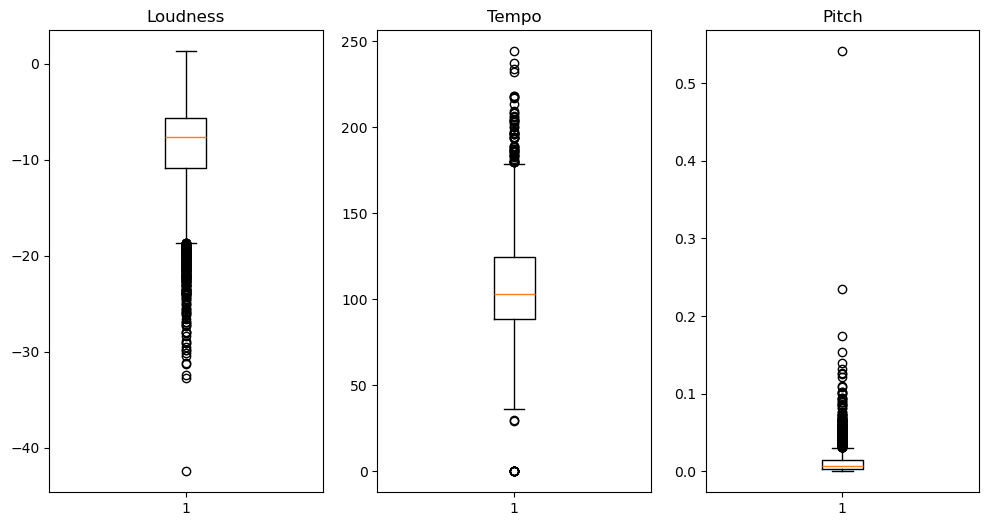

In [62]:
import matplotlib.pyplot as plt

# Plotting box plots to visualize outliers
plt.figure(figsize=(12, 6))

# Loudness Boxplot
plt.subplot(1, 3, 1)
plt.boxplot(df['loudness'])
plt.title('Loudness')

# Tempo Boxplot
plt.subplot(1, 3, 2)
plt.boxplot(df['tempo'])
plt.title('Tempo')

# Pitch Boxplot
plt.subplot(1, 3, 3)
plt.boxplot(df['pitch'])
plt.title('Pitch')

plt.show()

In [63]:
# Data Cleaning
# 1. Turning the song title and and artist name into numerical fields using one hot encoding since it is categorical (i.e., target variables or features) into integer codes. It maps each unique label to an integer., we are able to drop song title/song ID an artist name/artistID since we have converted the columns into numerical values.
# The reason why we want to include this information in our initial data since this kind of information may bring in some insights that we may not know

# Apply one-hot encoding to the object columns
from sklearn.preprocessing import OneHotEncoder

# Identify object columns
object_columns = df.select_dtypes(include=['object']).columns
# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' for avoiding multicollinearity

# Fit and transform the data
encoded_features = encoder.fit_transform(df[object_columns])

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(object_columns))

# Concatenate with the original DataFrame
df = pd.concat([df.drop(columns=object_columns), encoded_df], axis=1)



# 2. Removing Outliers from the data loudness Tempo and Pitch as we could see from the boxplot, standard deviation and IQR method there are outliers in the data.
# Outliers may affect our model results/accuracy and it is important to remove 

df = df[~df.index.isin(outliers_loudness.index)]
df = df[~df.index.isin(outliers_tempo.index)]
df = df[~df.index.isin(outliers_pitch.index)]

# Check the cleaned data
print("Outliers Dropped:")
print(df.shape)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Outliers Dropped:
(6809, 16800)


In [65]:
# model building

# Splitting data into training and testing sets
train_df = df[df['year'] <= 2009]
test_df = df[df['year'] == 2010]

# Building a logistic regression model to predict Top10 using the training data.
X_train = train_df.drop(columns="Top10")
y_train = train_df["Top10"]

# Adding a constant column for the intercept
X_train_sm = sm.add_constant(X_train)

# Building the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Displaying the summary
result.summary()

In [9]:
# Making predictions on the test set
X_train = train_df.drop(columns="Top10")
y_train = train_df["Top10"]
log_reg = LogisticRegression(max_iter=10000)

# Fit the model using sklearn
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = log_reg.predict_proba(X_train)[:, 1]   # Probabilities of being in the "Top10" category

predicted_classes = (y_pred_prob > 0.15).astype(int)  # Convert probabilities to class predictions based on a threshold of 0.15

# Creating a confusion matrix
conf_matrix = confusion_matrix(y_train, predicted_classes)

# Computing the accuracy rate on the test set
test_accuracy = (predicted_classes == y_train).mean()

print("Confusion Matrix:")
print(conf_matrix)
print(f"Test Accuracy: {test_accuracy:.4f}")

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, predicted_classes)
recall = recall_score(y_train, predicted_classes)
f1 = f1_score(y_train, predicted_classes)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Confusion Matrix:
[[3916 1567]
 [ 277  702]]
Test Accuracy: 0.7146
Precision: 0.3094
Recall: 0.7171
F1 Score: 0.4323


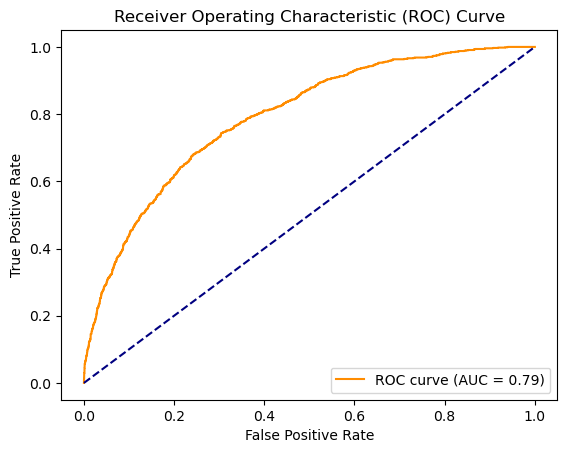

In [10]:
# Generating the ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Question 1 [15 pts]: Fit a logistic regression model using all variable

A logistic regression model is used to predict whether a song would reach top 10 on the BillBoard Hot 100 Chart. This analysis was done by using all musical features in the data provided. This model was able to achieve an accuracy of 71.46% and an AUC of 0.79, meaning that it was able to tell the difference between popular and un-popular songs. 

Steps taken for the analysis:
1. Importing the music dataset - 7573 records and 39 fields
2. Checking the data for any missing values, missing values can cause a bias in the model and could potentially reduce the accuracy and effective of the model- No null values were found
3. Checking the data for outliers, Models, like linear and logistic regression, optimize for minimizing error, they might get pulled towards these outlier points, which can lead to reducing the accuracy of the model. In this analysis we used the IQR method to remove outliers. After reviewing the loudness, tempo and pitch features, there are outliers in the dataset and are removed for the the model.
4. Conversion of object variables to numerical. Models are only able to use numerical variables, since song and artists are objects, they will need to be converted to numerical using label encoder. With this converted to numerical, we will be able to use all variables for the model
5. Splitting the data into train and test - anything before 2009 will be our train data and songs in 2010 will be used to predict whether or not a song will make top 10.
6. Performing a logistic Regression on Train data - Year, timesignature_confidence, loudness, tempo_confidence, energy, pitch, timbre and artist name all have a p value < 0.05 meaning they are significant to the model
7. Performing a Confusion Matrix on test data - This showed an accuracy of 71.47%
    True Negatives = 3916 of making it top 10
    False Positives = 1567 of making it top 10
    False Negative = 277 of making it top 10
    True Positives = 702 of making it top 10
    1567 cases where it was classified as making it top 10 - Type 1 Error
    277 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

8. Performing an ROC Curve on test data, provides insights into how well the model distinguishes between the positive and negative classes, independent of the decision threshold.
    •	AUC = 0.5: No discriminative power (same as random guessing).
	•	AUC < 0.5: Worse than random guessing (rare in practice).
	•	AUC > 0.5: The model has some discriminatory power. Higher AUC values indicate better model performance.

    AUC = 0.79 chance that the model will rank a randomly chosen positive instance (Top 10 song) higher than a randomly chosen negative instance (not Top 10 song). This is a good indication that your model has high discriminatory power, effectively distinguishing between hits and non-hits.

These findings provide valuable insights for music producers and marketers to optimize their strategies for promoting potential hit songs.




In [11]:
X_test = test_df.drop(columns=['Top10'])  # Features for testing
y_test = test_df['Top10']  # True labels for testing

# Predict probabilities of being in the "Top10" category
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of being in the Top 10

# Set a threshold to decide class labels; e.g., use 0.5 as a typical threshold
predicted_classes = (y_pred_prob > 0.15).astype(int)  # Using a threshold of 0.5 for binary classification

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
test_accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {test_accuracy:.4f}")

# Precision
precision = precision_score(y_test, predicted_classes)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, predicted_classes)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, predicted_classes)
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
[[204  86]
 [ 13  44]]
Accuracy: 0.7147
Precision: 0.3385
Recall: 0.7719
F1 Score: 0.4706


### Question 2 [15 pts]: Predict the popularity of records in the testing set.


A logistic regression model is used to predict whether a song would reach top 10 on the BillBoard Hot 100 Chart. This analysis was done by using all musical features in the data provided. This model was able to achieve an accuracy of 71.47% and an AUC of 0.82, meaning that it was able to tell the difference between popular and un-popular songs. 

Steps taken for the analysis:
1. Importing the music dataset - 7573 records and 39 fields
2. Checking the data for any missing values, missing values can cause a bias in the model and could potentially reduce the accuracy and effective of the model- No null values were found
3. Checking the data for outliers, Models, like linear and logistic regression, optimize for minimizing error, they might get pulled towards these outlier points, which can lead to reducing the accuracy of the model. In this analysis we used the IQR method to remove outliers. After reviewing the loudness, tempo and pitch features, there are outliers in the dataset and are removed for the the model.
4. Conversion of object variables to numerical. Models are only able to use numerical variables, since song and artists are objects, they will need to be converted to numerical using label encoder. With this converted to numerical, we will be able to use all variables for the model
5. Splitting the data into train and test - anything before 2009 will be our train data and songs in 2010 will be used to predict whether or not a song will make top 10.
6. Performing a logistic Regression - Year, timesignature_confidence, loudness, tempo_confidence, energy, pitch, timbre and artist name all have a p value < 0.05 meaning they are significant to the model


7. Confusion Matrix
    True Negatives = 204 of making it top 10
    False Positives = 86 of making it top 10
    False Negative = 13 of making it top 10
    True Positives = 44 of making it top 10

    86 cases where it was classified as making it top 10 - Type 1 Error
    44 Cases where it was classified as not making it top 10 when it should have - Type 2 Error

Ways to improve the model:

	1.	Threshold Adjustment - Lowering the threshold from 0.5 to increase recall which will help in reducing the number of false negatives.
	2.	Rebalancing the Dataset: If the dataset is imbalanced (fewer hits compared to non-hits), techniques like oversampling the minority class (hits) or undersampling the majority class (non-hits) can be used to improve recall.
	3.	Model Refinement: Explore feature engineering, adding new features, or using more complex models like ensemble methods to capture more nuanced patterns in the data.
	4.	Context-Specific Optimization: Depending on whether precision or recall is more critical, you can fine-tune the model. For example, if catching all potential hits is crucial, prioritize recall.

good overall accuracy and precision, but it struggles with recall, indicating a need to balance the model’s conservativeness with the need to capture true positives. Further tuning and potentially using a different threshold could improve recall without significantly compromising precision. Understanding these trade-offs is essential for optimizing the model’s performance based on business objectives.



Question 3 [15 pts]:  Generate the ROC curve 

The ROC curve helps us understand how well the logistic regression is able to distinguish between the two classes, positive (Top 10) and negative (Not top 10).
Analyzing the ROC Training data - AUC of 0.79 indicates good discriminatory power, meaning the model has a 79% chance of correctly distinguishing between a randomly chosen positive case (Top 10 song) and a randomly chosen negative case (non-Top 10 song). This suggests that the model is effective at learning the patterns in the training data.

Analyzing the ROC Test data - AUC of 0.82 indicates that the model performs slightly better on the testing set than on the training set in terms of its ability to discriminate between hits and non-hits. This AUC value is higher, suggesting the model generalizes well and is reliable when applied to unseen data.

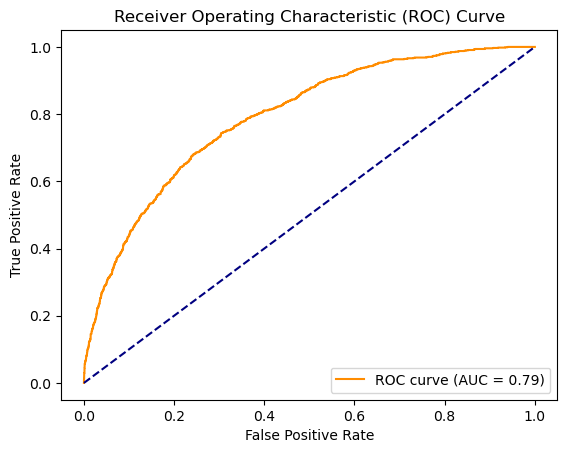

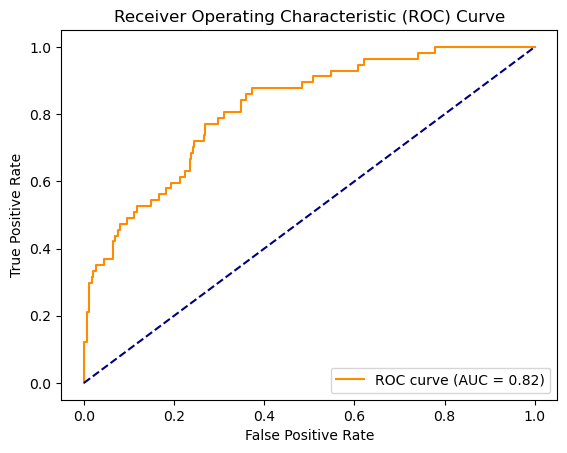

In [18]:
# Generating the ROC curve
# Predict probabilities of being in the "Top10" category
y_pred_prob = log_reg.predict_proba(X_train)[:, 1]  # Probability of being in the Top 10

# Set a threshold to decide class labels; e.g., use 0.5 as a typical threshold
predicted_classes = (y_pred_prob > 0.15).astype(int)  # Using a threshold of 0.5 for binary classification

fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generating the ROC curve
# Predict probabilities of being in the "Top10" category
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability of being in the Top 10

# Set a threshold to decide class labels; e.g., use 0.5 as a typical threshold
predicted_classes = (y_pred_prob > 0.15).astype(int)  # Using a threshold of 0.5 for binary classification

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# # Splitting data into training and testing sets
# train_df = df[df['year'] <= 2009]
# test_df = df[df['year'] == 2010]

# # we want to exclude some of the variables in our dataset from being used as independent variables
# # ("year", "songtitle", "artistname", "songID", and "artistID").
# columns_to_exclude = ["year", "songtitle", "artistname", "songID", "artistID"]

# # To remove these variables from training and testing sets:
# train_df = train_df.drop(columns=columns_to_exclude)
# test_df = test_df.drop(columns=columns_to_exclude)

# # Building a logistic regression model to predict Top10 using the training data.
# X_train = train_df.drop(columns="Top10")
# y_train = train_df["Top10"]

# # Adding a constant column for the intercept
# X_train_sm = sm.add_constant(X_train)

# # Building the logistic regression model using statsmodels
# logit_model = sm.Logit(y_train, X_train_sm)
# result = logit_model.fit()

# # Displaying the summary
# result.summary()

True or False?
1. The higher our confidence about time signature, key and tempo, the more likely the song is to be in the Top 10
2. In general, if the confidence is low for the time signature, tempo, and key, then the song is more likely to be complex. What does our model suggest in terms of complexity?

In [ ]:
# # Making predictions on the test set
# X_test = test_df.drop(columns="Top10")
# y_test = test_df["Top10"]

# y_pred_prob = log_reg.predict_proba(X_test)[:, 1]   # Probabilities of being in the "Top10" category

# predicted_classes = (y_pred_prob > 0.15).astype(int)  # Convert these probabilities into class predictions (i.e., 1 for "Top10" and 0 otherwise) based on a threshold 0.15.

# # Creating a confusion matrix
# conf_matrix = confusion_matrix(y_test, predicted_classes)

# # Computing the accuracy rate on the test set
# test_accuracy = (predicted_classes == y_test).mean()

# print(conf_matrix)
# print(test_accuracy)

NameError: name 'test_df' is not defined

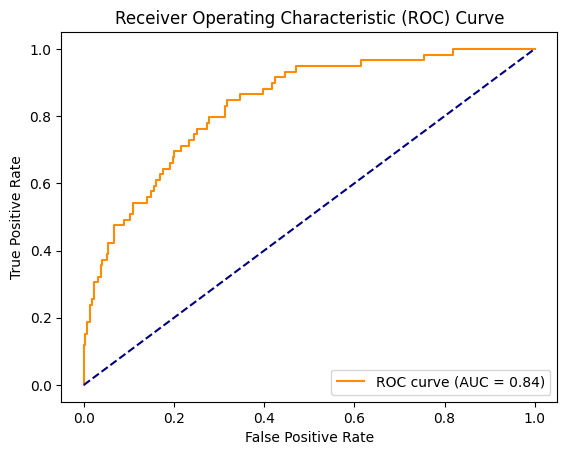

In [ ]:
# # Generating the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# # Plotting the ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [17]:
# import pandas as pd
# import statsmodels.api as sm

# # Assuming df is already loaded
# # Splitting data into training and testing sets
# train_df = df[df['year'] <= 2009]
# test_df = df[df['year'] == 2010]

# # Defining columns to exclude
# columns_to_exclude = ["year", "songtitle", "artistname", "songID", "artistID"]

# # Removing these variables from training and testing sets
# train_df = train_df.drop(columns=columns_to_exclude)
# test_df = test_df.drop(columns=columns_to_exclude)

# # Building a logistic regression model to predict Top10 using the training data
# X_train = train_df.drop(columns="Top10")
# y_train = train_df["Top10"]

# # Adding a constant column for the intercept
# X_train_sm = sm.add_constant(X_train)

# # Building the logistic regression model using statsmodels
# logit_model = sm.Logit(y_train, X_train_sm)
# result = logit_model.fit()

# # Displaying the summary
# print(result.summary())

Optimization terminated successfully.
         Current function value: 0.330451
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Top10   No. Observations:                 7201
Model:                          Logit   Df Residuals:                     7167
Method:                           MLE   Df Model:                           33
Date:                Sat, 17 Aug 2024   Pseudo R-squ.:                  0.2091
Time:                        14:35:11   Log-Likelihood:                -2379.6
converged:                       True   LL-Null:                       -3008.8
Covariance Type:            nonrobust   LLR p-value:                2.683e-243
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       14.7000      1.806      8.138      0.000      11.160